In [1]:
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings 
warnings.filterwarnings('ignore')
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\xxran\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Read in original csv from my GitHub
initDataDf = pd.read_csv("https://raw.githubusercontent.com/JordanVencel/DFProject/main/Tesla.csv")
# Filter out tweets that are not in english 
filterDf = initDataDf[['language','tweet']]
filterDf = filterDf.where(filterDf['language'] == 'en')
filterDf = filterDf[filterDf['language'].notna()]
# Grab only tweet text data
tweetDf = filterDf['tweet'].to_frame()
tweetDf = tweetDf.reset_index(drop=True)

# Filter out @s, hashtags, external links, and other irrelavant information using regex
for row in tweetDf.iterrows():
    index = row[0]
    booty = re.sub(r"([@#])\w+", "", row[1][0])
    booty = re.sub(r"(https)([^\s]+)", "", booty)
    booty = re.sub(r"(\?)", "", booty)
    booty = re.sub(r"(.com)", "", booty)
    booty = re.sub(r"([^A-Za-z'\"\s])", "", booty)
    booty = re.sub(r"(^[ \t]+)", "", booty)
    booty = re.sub('"', '', booty)
    booty = re.sub("'", '', booty)
    booty = booty.lower()
    tweetDf.iloc[index][0] = booty

# Removes words that are less than 4 letters long
tweetDf.tweet = tweetDf.tweet.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
# replaces the empty tweets with NaN
tweetDf = tweetDf.tweet.apply(lambda x: x.strip()).replace('', np.nan).to_frame()
# Removes rows with NaN vals
tweetDf = tweetDf.dropna()

tweetDf.head()

,tweet
0,have them still live home being homeschooled t...
1,then your dozen kids just missing more
2,about buying country could turn into richest c...
3,actual receipts havent asked anyone tesla grif...
4,tesla wall battery save power went still when ...


In [3]:
# Set up row id formatting for nltk
import sys
tweetDf['row_id'] = 0
tweetDf = tweetDf[['row_id', 'tweet']]
for row in tweetDf.iterrows():
    index = row[0]
    newVal = int(index) + 1
    tweetDf['row_id'][index] = newVal

In [4]:
sentimentDf = pd.DataFrame()
sentimentDf['row_id'] = ['99999999999']
sentimentDf['sentiment_type'] = 'NA999NA'
sentimentDf['sentiment_score'] = 0

print('Processing sentiment analysis...')
sia = SentimentIntensityAnalyzer()
tempDf = sentimentDf
for index, row in tweetDf.iterrows():
    scores = sia.polarity_scores(row[1])
    for key, value in scores.items():
        temp = [key,value,row[0]]
        sentimentDf['row_id'] = row[0]
        sentimentDf['sentiment_type'] = key
        sentimentDf['sentiment_score'] = value
        tempDf = tempDf.append(sentimentDf)

#remove dummy row with row_id = 99999999999
tempDf_cleaned = tempDf[tempDf.row_id != '99999999999']
#remove duplicates if any exist
tempDf_cleaned = tempDf_cleaned.drop_duplicates()
# only keep rows where sentiment_type = compound
tempDf_cleaned = tempDf[tempDf.sentiment_type == 'compound']

print(tempDf_cleaned)

Processing sentiment analysis...
    row_id sentiment_type  sentiment_score
0        1       compound          -0.4767
0        2       compound          -0.2960
0        3       compound           0.5267
0        4       compound           0.4404
0        5       compound           0.4939
..     ...            ...              ...
0     7354       compound           0.4215
0     7355       compound          -0.0516
0     7356       compound           0.0000
0     7357       compound           0.6808
0     7358       compound           0.6124

[7340 rows x 3 columns]


In [5]:
tempDf_cleaned = tempDf_cleaned.reset_index(drop=True)
tempDf_cleaned

,row_id,sentiment_type,sentiment_score
0,1,compound,-0.4767
1,2,compound,-0.2960
2,3,compound,0.5267
3,4,compound,0.4404
4,5,compound,0.4939
...,...,...,...
7335,7354,compound,0.4215
7336,7355,compound,-0.0516
7337,7356,compound,0.0000
7338,7357,compound,0.6808


In [6]:
recombined_df = pd.DataFrame(columns=['row_id', 'tweet', 'sentiment_type', 'sentiment_score'])
recombined_df['tweet'] = tweetDf['tweet']
recombined_df[['row_id', 'sentiment_type', 'sentiment_score']] = tempDf_cleaned[['row_id', 'sentiment_type', 'sentiment_score']]
recombined_df

,row_id,tweet,sentiment_type,sentiment_score
0,1.0,have them still live home being homeschooled t...,compound,-0.4767
1,2.0,then your dozen kids just missing more,compound,-0.2960
2,3.0,about buying country could turn into richest c...,compound,0.5267
3,4.0,actual receipts havent asked anyone tesla grif...,compound,0.4404
4,5.0,tesla wall battery save power went still when ...,compound,0.4939
...,...,...,...,...
7353,NaN,elon musk liked tweet from whole mars catalog ...,NaN,NaN
7354,NaN,dude only said buying twitter sell billion tes...,NaN,NaN
7355,NaN,give your tesla,NaN,NaN
7356,NaN,chick should definitely public they shouldve t...,NaN,NaN


In [7]:
from gensim.models import Word2Vec, FastText
import pandas as pd 
import re 

from sklearn.decomposition import PCA

from matplotlib import  pyplot as plt 
import plotly.graph_objects as go 

import numpy as np 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(recombined_df['tweet'])
#tfidf_matrix = tfidf.fit_transform(recombined_df.tweet).todense()
#vocab = tfidf.vocabulary
#print(vocab)

In [9]:
tokenized_tweet = recombined_df['tweet'].apply(lambda x: x.split())
w2v = Word2Vec(tokenized_tweet, min_count=5, vector_size=200, window=5, sg = 1, hs=0, workers=32, seed=34, negative=10)
w2v.train(tokenized_tweet, total_examples=len(recombined_df['tweet']), epochs=20)
#print(w2v)

#Word2Vec(vector_size=2, alpha=0.025)

(1319989, 1873520)

In [10]:
w2v.wv.most_similar(positive='elon')

[('musk', 0.6889893412590027),
 ('donald', 0.5723800659179688),
 ('mock', 0.5594950318336487),
 ('rival', 0.5573781132698059),
 ('defends', 0.5455418229103088),
 ('trolling', 0.5448870658874512),
 ('amid', 0.5443469285964966),
 ('rips', 0.5403072237968445),
 ('snubs', 0.5314725637435913),
 ('bullst', 0.529603123664856)]

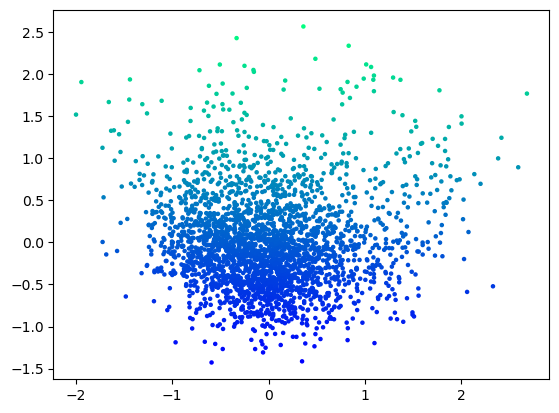

In [11]:
import seaborn as sns
X = w2v.wv[w2v.wv.key_to_index]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
colors = ["darkgreen", "mediumseagreen", "lightgreen"]
x = result[:, 0]
y = result[:, 1]
plt.scatter(x, y, c=y, s=5,cmap='winter')



words = list(w2v.wv.key_to_index)

#for i, word in enumerate(words):
 # plt.annotate(word, xy=(result[i, 0], result[i,1]))

plt.show()
#fig.show()

In [12]:
#for w in w2v.wv.key_to_index:
#    print (w, w2v.wv[w].count)
import re

words = w2v.wv.index_to_key
clean_words = []
usless_words = []
for word in words:
    if (len(word) > 3):
        clean_words.append(word)
    else:
        usless_words.append(word)

word_dict = {}
total_words = 0
total_usefull = 0
total_useless = 0
useless_dict = {}
total_dict = {}
for tweets in tokenized_tweet:
    for x in tweets:
        total_words += 1

        if (x in clean_words):
            total_usefull += 1
        if (x in usless_words):
            total_useless +=1

        if ((x in useless_dict) and (x in usless_words)):
            useless_dict[x] += 1
        elif ((x not in useless_dict) and (x in usless_words)):
            useless_dict[x] = 1

        if (x in word_dict and x in clean_words):
            word_dict[x] += 1
        elif (x not in word_dict and x in clean_words):
            word_dict[x] = 1

In [16]:
#{k: v for k, v in sorted(word_dict.items(), reverse=True, key=lambda item: item[1])}
#{k: v for k, v in sorted(useless_dict.items(), reverse=True, key=lambda item: item[1])}



<AxesSubplot:>

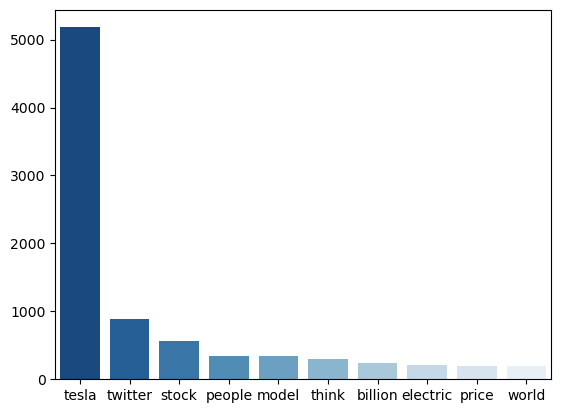

In [14]:
import seaborn as sns
data = {'words': ['tesla', 'twitter', 'stock', 'people', 'model', 'think', 'billion', 'electric', 'price', 'world'],
        'freq': [5181,891,557,337,336,302,244,211,194,191]}
usefull_df = pd.DataFrame(data=data)

sns.barplot(data=data, x="words", y="freq", palette= "Blues_r")

<AxesSubplot:>

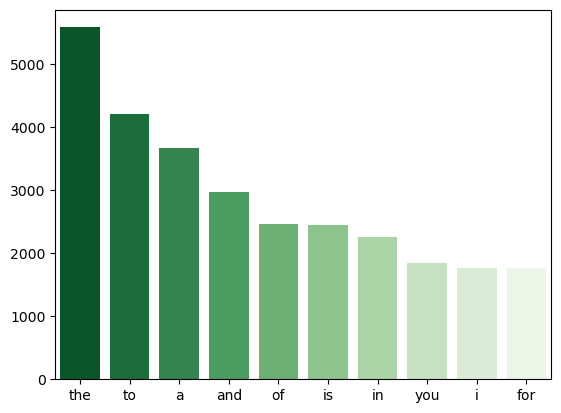

In [15]:
'''
'the': 5582,
 'to': 4206,
 'a': 3673,
 'and': 2966,
 'of': 2462,
 'is': 2449,
 'in': 2264,
 'you': 1846,
 'i': 1763,
 'for': 1762,
'''
data = {'words': ['the', 'to', 'a', 'and', 'of', 'is', 'in', 'you', 'i', 'for'],
        'freq': [5582, 4206, 3673, 2966, 2462, 2449, 2264, 1846, 1763, 1762]}
useless_df = pd.DataFrame(data=data)

sns.barplot(data=data, x="words", y="freq", palette="Greens_r")